# Metabolic Task Visualizer

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/earmingol/scCellFie/blob/main/docs/source/notebooks/visualizer.ipynb)

In this tutorial, we will walk you through how to export scCellFie's inferred metabolic activities to be visualized in the [scCellFie Metabolic Task Visualizer](https://www.sccellfie.org).

The visualizer enables users to drag and drop the `.csv` output to visualize results interactively through the portal. 

![Figure 1.](https://raw.githubusercontent.com/earmingol/scCellFie/refs/heads/main/docs/source/_static/visualizer/interactive_visualiser.png)

The dataset we are using is a [downsampled version of the Endometrium dataset](https://zenodo.org/records/15072628/files/HECA-Subset.h5ad) of [The Repoductive Cell Atlas](https://www.reproductivecellatlas.org/) [(Mareckova & Garcia-Alonso et al 2023)](https://doi.org/10.1038/s41588-024-01873-w).

## This tutorial includes following steps:
* [Loading libraries](#loading-libraries)
* [Loading endometrium data](#loading-endometrium-data)
* [Run scCellFie](#run-sccellfie)
* [Export results](#export-results)
* [Online visualizations](#online-visualizations)
* [Additional local visualizations](#additional-local-visualizations)

## Loading libraries  <a class="anchor" id="loading-libraries"></a>

In [ ]:
import sccellfie
import scanpy as sc
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import glasbey

## To avoid warnings
import warnings
warnings.filterwarnings("ignore")

/software/cellgen/team283/tl7/envs/scvi-env/lib/python3.12/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/software/cellgen/team283/tl7/envs/scvi-env/lib/python3.12/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


First, let's define file paths for all results of our analysis

In [ ]:
results_dir = './results/endometrium2023/'

## Loading endometrium data <a class="anchor" id="loading-endometrium-data"></a>

The downsampled Endometrium dataset contains 90001 cells `(n_obs)` with 17736 genes `(n_vars)`.

This is a processed data, with raw count matrix stored in `.X`, including 36 cell type annotations in `.obs['celltype']`.

In [ ]:
adata = sc.read(filename='./data/HECA-Subset.h5ad',
                backup_url='https://zenodo.org/records/15072628/files/HECA-Subset.h5ad')

In [ ]:
adata

AnnData object with n_obs × n_vars = 90001 × 17736
    obs: 'n_genes', 'sample', 'percent_mito', 'n_counts', 'Endometriosis_stage', 'Endometriosis', 'Hormonal treatment', 'Binary Stage', 'Stage', 'phase', 'dataset', 'Age', 'lineage', 'celltype', 'label_long'
    var: 'gene_ids', 'feature_types'
    uns: 'Binary Stage_colors', 'Biopsy_type_colors', 'Endometrial_pathology_colors', 'Endometriosis_stage_colors', 'GarciaAlonso_celltype_colors', 'Group_colors', 'Hormonal treatment_colors', 'Library_genotype_colors', 'Mareckova_celltype_colors', 'Mareckova_epi_celltype_colors', 'Mareckova_lineage_colors', 'Processing_colors', 'Symbol_colors', 'Tan_cellsubtypes_colors', 'Tan_celltype_colors', 'Treatment_colors', 'celltype_colors', 'dataset_colors', 'genotype_colors', 'hvg', 'label_long_colors', 'leiden', 'leiden_R_colors', 'leiden_colors', 'lineage_colors', 'neighbors', 'phase_colors', 'umap'
    obsm: 'X_scVI', 'X_umap'
    obsp: 'connectivities', 'distances'

In [ ]:
adata.uns['neighbors']

{'connectivities_key': 'connectivities',
 'distances_key': 'distances',
 'params': {'method': 'umap',
  'metric': 'euclidean',
  'n_neighbors': 15,
  'random_state': 0,
  'use_rep': 'X_scVI'}}

However, we need the raw counts of all genes. So we load the raw version of it and transfer annotations from the processed dataset.

## Run scCellFie <a class="anchor" id="run-sccellfie"></a>

Now we run scCellFie on the raw data.

`scCellFie` provides an option to compute `n_neighbors`. Since the this dataset contains a pre-computed `.uns['neighbors']`, we will use `neighbors_key='neighbors'` instead.

Users may also want to tweak the parameter `chunk_size` for computing large datasets on local machines.

In [ ]:
results = sccellfie.run_sccellfie_pipeline(adata, 
                                           organism='human',
                                           sccellfie_data_folder=None,
                                           n_counts_col='n_counts', 
                                           process_by_group=False, 
                                           groupby=None, 
                                           neighbors_key='neighbors',
                                           batch_key=None,  # Specify batch_key or leave as None
                                           threshold_key='sccellfie_threshold', 
                                           smooth_cells=True, 
                                           alpha=0.33,
                                           chunk_size=5000,
                                           disable_pbar=False, 
                                           save_folder=None,
                                           save_filename=None
                                          )


==== scCellFie Pipeline: Initializing ====
Loading scCellFie database for organism: human

==== scCellFie Pipeline: Processing entire dataset ====

---- scCellFie Step: Preprocessing data ----

---- scCellFie Step: Preparing inputs ----
Gene names corrected to match database: 22
Shape of new adata object: (90001, 839)
Number of GPRs: 748
Shape of tasks by genes: (215, 839)
Shape of reactions by genes: (748, 839)
Shape of tasks by reactions: (215, 748)

---- scCellFie Step: Smoothing gene expression ----


Smoothing Expression: 100%|██████████| 19/19 [00:45<00:00,  2.41s/it]



---- scCellFie Step: Computing gene scores ----

---- scCellFie Step: Computing reaction activity ----


Cell Rxn Activities: 100%|██████████| 90001/90001 [10:03<00:00, 149.07it/s]



---- scCellFie Step: Computing metabolic task activity ----
Removed 0 metabolic tasks with zeros across all cells.

==== scCellFie Pipeline: Processing completed successfully ====


## Export results <a class="anchor" id="export-results"></a>

The scCellFie results are stored as dictionary and can be retrieved by the dictionary keys.

In [ ]:
results.keys()

dict_keys(['adata', 'gpr_rules', 'task_by_gene', 'rxn_by_gene', 'task_by_rxn', 'rxn_info', 'task_info', 'thresholds', 'organism'])

To access metabolic activities, we need to inspect ``results['adata']``:

- The processed single-cell data is located in the AnnData object ``results['adata']``.
- The reaction activities for each cell are located in the AnnData object ``results['adata'].reactions``.
- The metabolic task activities for each cell are located in the AnnData object ``results['adata'].metabolic_tasks``.

In particular:

- ``results['adata']``: contains gene expression in ``.X``.
- ``results['adata'].layers['gene_scores']``: contains gene scores as in the original CellFie paper.
- ``results['adata'].uns['Rxn-Max-Genes']``: contains determinant genes for each reaction per cell.
- ``results['adata'].reactions``: contains reaction scores in ``.X`` so every scanpy function can be used on this object to visualize or compare values.
- ``results['adata'].metabolic_tasks``: contains metabolic task scores in ``.X`` so every scanpy function can be used on this object to visualize or compare values.

Other keys in the ``results`` dictionary are associated with the scCellFie database and are already filtered for the elements present
in the dataset (``'gpr_rules'``, ``'task_by_gene'``, ``'rxn_by_gene'``, ``'task_by_rxn'``, ``'rxn_info'``, ``'task_info'``, ``'thresholds'``, ``'organism'``).

### Summarise results into a table to use on [scCellFie Metabolic Task Visualizer](https://www.sccellfie.org)

We want metabolic scores at a cell type level. Here, the column summarizing these groups is `'celltype'`.

In [ ]:
cell_group = 'celltype'

In [ ]:
report = sccellfie.reports.generate_report_from_adata(results['adata'].metabolic_tasks, cell_group, feature_name='metabolic_task')

Processing tissues: 100%|██████████| 1/1 [00:04<00:00,  4.81s/it]


In [ ]:
report.keys()

dict_keys(['agg_values', 'variance', 'std', 'threshold_cells', 'nonzero_cells', 'cell_counts', 'min_max', 'melted'])

### Saving scCellFie reports

Once we have our report data to export, we can save it with the following function in a specific output folder:

In [ ]:
sccellfie.io.save_data.save_result_summary(results_dict=report, output_directory=results_dir)

Results saved to ./results/endometrium2023/


This function generates multiple CSV files, the ones that we need are `Melted.csv` which contains the metabolic activities per task for each of the cell types. Another useful file is the `Min_max.csv` in case we would like to explore the range of scores for each metabolic task either in a single-cell or cell-type level.

### Computing scaled trimean using CELLxGENE reference

The `Melted.csv` file already contains a `'scaled_trimean'` column in case we would like to visualize scaled values. However, this is by using the min and max values within the dataset. In case we would like to compare it with different organs and cell types at a cell atlas level, we can use the outputs generated by using the CZI CELLxGENE atlas to scale our metabolic activities.

We start first downloading the range of min and max values in the CZI's atlas:

In [ ]:
minmax = pd.read_csv('https://raw.githubusercontent.com/ventolab/sccellfie-website/refs/heads/main/data/CELLxGENEMetabolicTasksMinMax.csv', index_col=0)

In [ ]:
minmax

,(R)-3-Hydroxybutanoate synthesis,3'-Phospho-5'-adenylyl sulfate synthesis,AMP salvage from adenine,ATP generation from glucose (hypoxic conditions) - glycolysis,ATP regeneration from glucose (normoxic conditions) - glycolysis + krebs cycle,Acetoacetate synthesis,Alanine degradation,Alanine synthesis,Arachidonate degradation,Arachidonate synthesis,...,Valine to succinyl-coA,Vesicle secretion,beta-Alanine degradation,beta-Alanine synthesis,cis-vaccenic acid degradation,cis-vaccenic acid synthesis,gamma-Linolenate degradation,gamma-Linolenate synthesis,glyco-cholate synthesis,tauro-cholate synthesis
single_cell_min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
single_cell_max,7.419829,11.795217,20.651447,13.613079,4.979552,8.038148,3.030361,7.951063,1.752682,4.296328,...,6.424888,2.780753,2.980583,6.203485,2.161476,4.050148,2.341566,7.578767,2.982760,2.982760
cell_type_min,0.041299,0.000000,0.000000,0.033310,0.024252,0.023852,0.028060,0.025760,0.000000,0.021624,...,0.000000,0.000000,0.025981,0.029364,0.000000,0.013848,0.000000,0.000000,0.000000,0.000000
cell_type_max,4.403184,4.105401,5.187688,7.840590,3.159272,4.670686,1.874831,4.480565,0.854841,2.594763,...,1.313472,0.798270,1.899791,3.463882,1.151658,2.225383,1.263210,1.716187,0.941299,0.941299


We then generate a dictionary containing the cell-type level info for each of the metabolic tasks:

In [ ]:
min_mapper = minmax.T['cell_type_min'].to_dict()
max_mapper = minmax.T['cell_type_max'].to_dict()

And use this information to scale the metabolic scores ('trimean' here) in our dataset.

In [ ]:
melted = report['melted'].copy()
melted['min'] = melted.metabolic_task.map(min_mapper)
melted['max'] = melted.metabolic_task.map(max_mapper)

melted['scaled_trimean'] = (melted['trimean'] - melted['min']) / (melted['max'] - melted['min'])
melted['scaled_trimean'] = melted['scaled_trimean'].apply(lambda x: 0. if x < 0. else 1. if x > 1. else x)

Finally we can generate a new `Melted.csv` file that includes the scaled values with respect to the CZI CELLxGENE atlas, and use it for visualization.

In [ ]:
melted.to_csv(f'{results_dir}Melted.csv', index=False)

## Online visualizations <a class="anchor" id="online-visualizations"></a>

Next, visit the [scCellFie Metabolic Task Visualizer](https://www.sccellfie.org) portal, you can Drag N' Drop your saved `Melted.csv` to visualise the result in a heatmap.

#### Step 1 - Drag N' Drop

![Figure 2.](https://raw.githubusercontent.com/earmingol/scCellFie/refs/heads/main/docs/source/_static/visualizer/drag_n_drop.png)

#### Step 2 - In the heatmap, hover your cursor over the tile to view the values 

![Figure 3.](https://raw.githubusercontent.com/earmingol/scCellFie/refs/heads/main/docs/source/_static/visualizer/endometrium_overview.png)

#### Step 3 - Subsetting the heatmap using the `Cell Type` and `Metabolic Task` boxes 

![Figure 4.](https://raw.githubusercontent.com/earmingol/scCellFie/refs/heads/main/docs/source/_static/visualizer/select_cellTypes.png)

## Additional local visualizations <a class="anchor" id="additional-local-visualizations"></a>

These outputs can be further used to visualize metabolic task activities with a radial plot. In this case, all cell types within the tissue are included. The maximum activity per task, across all cell types, is shown.

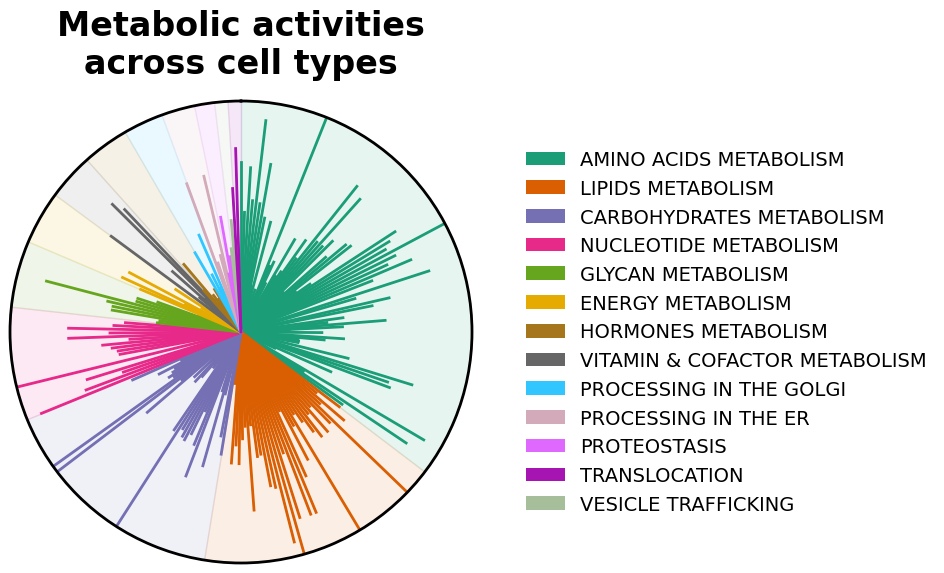

In [ ]:
fig, ax = sccellfie.plotting.create_radial_plot(melted, results['task_info'], figsize=(6,6), sort_by_value=False, ylim=1.0)

Or we can also plot the activities of each cell type:

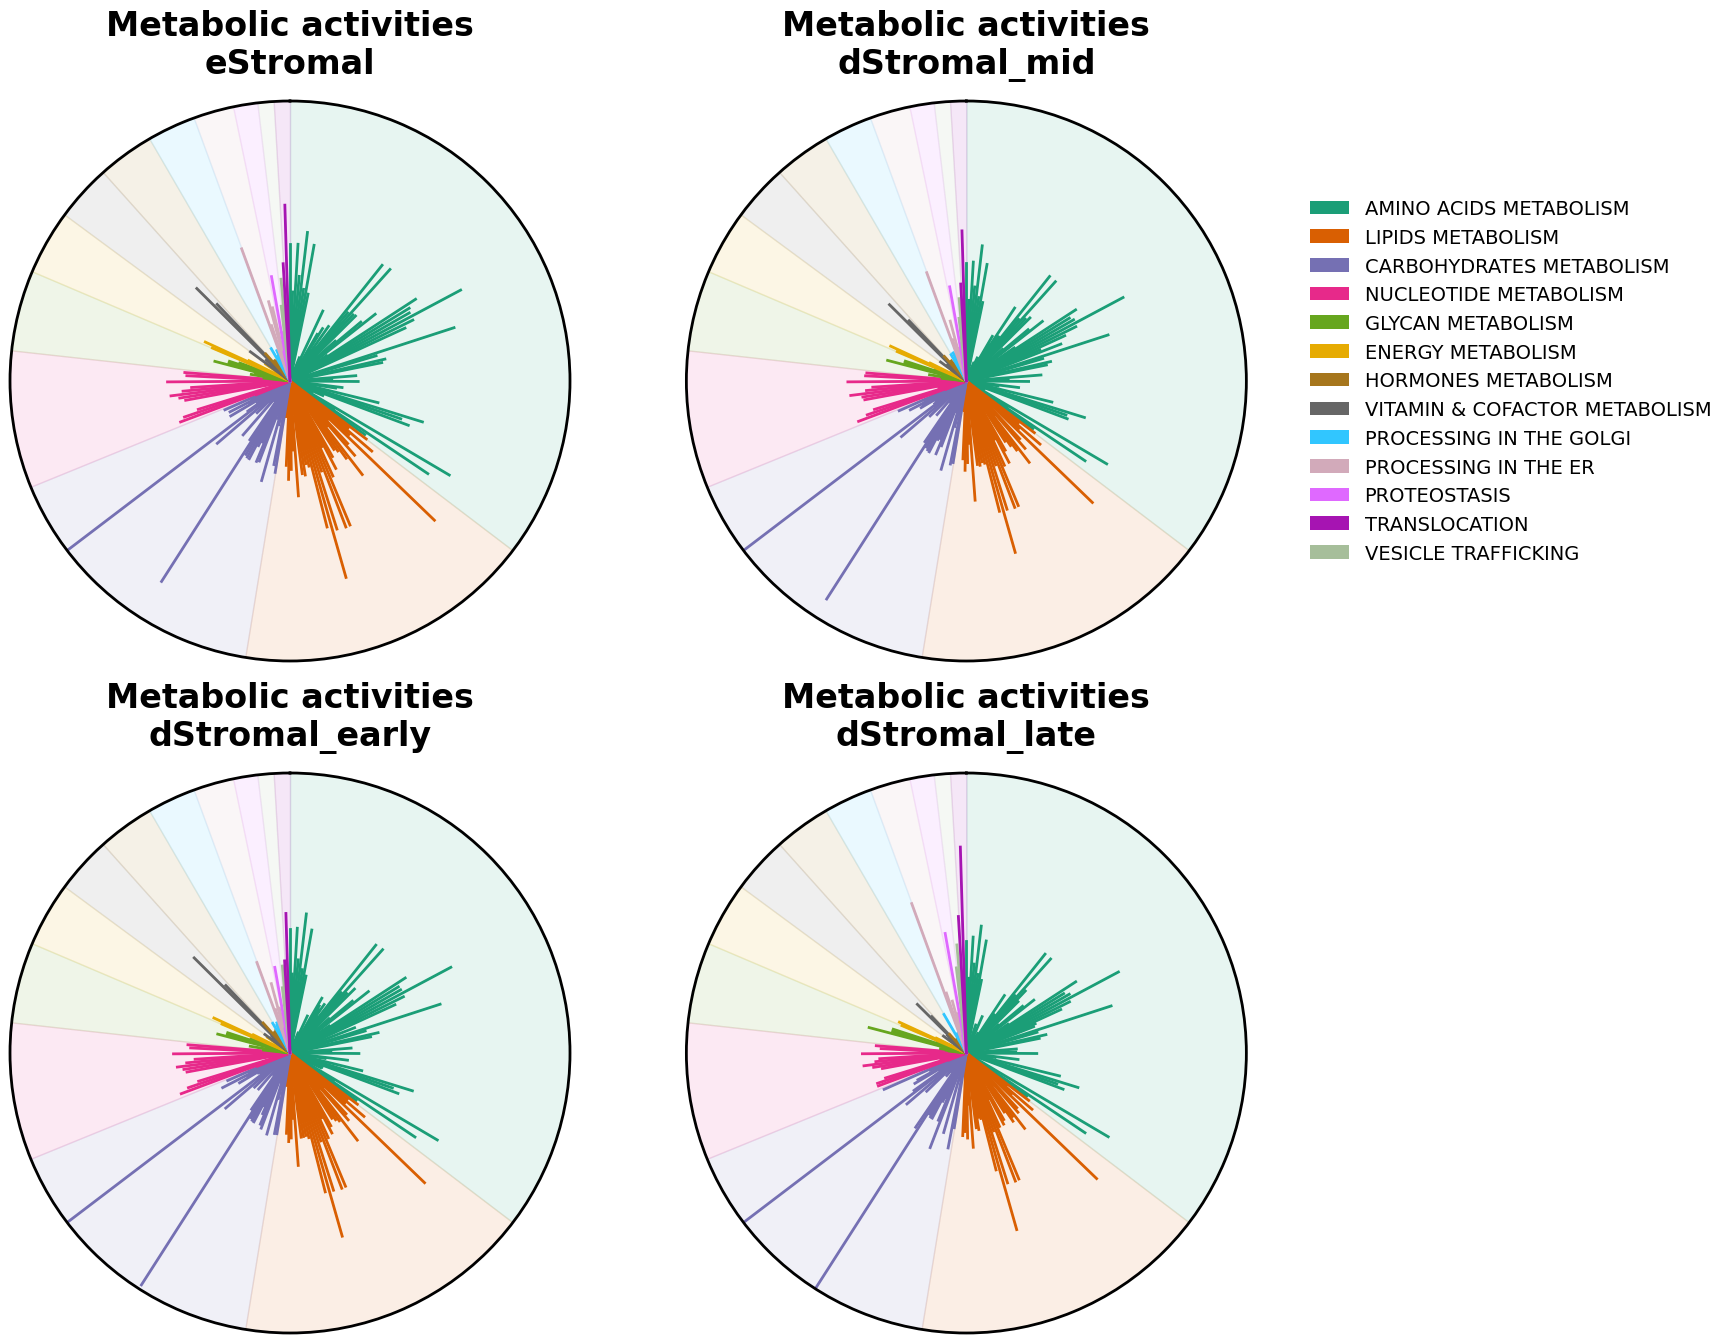

In [ ]:
# Create figure with subplots
fig = plt.figure(figsize=(16, 16))
ax1 = fig.add_subplot(221, projection='polar')
ax2 = fig.add_subplot(222, projection='polar')
ax3 = fig.add_subplot(223, projection='polar')
ax4 = fig.add_subplot(224, projection='polar')

for i, (cell, ax) in enumerate(zip(['eStromal', 'dStromal_mid', 'dStromal_early', 'dStromal_late'], [ax1, ax2, ax3, ax4])):
    sccellfie.plotting.create_radial_plot(melted, 
                                          results['task_info'],
                                          cell_type=cell,
                                          ax=ax,
                                          show_legend=i == 1,
                                          ylim=1.0
                                          )